# Prediction and Classification of Stellar Characteristics

Author: Benjamin Tong

Course Project, UC Irvine, Math 10, S24

I would like to post my notebook on the course's website. Yes

Astronomers have observed that the mass, luminosity, and radiuses of stars obey certain relationship. In this project, we will try to predict these characteristics from other characteristics using linear and k-nearest-neighbor regression models. We will also try to predict whether a star is main sequence or not using logistic regression. Finally, we will look at the distribution of masses in this sample by using histograms and kernel density.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

The dataset we will be training from is called [DEBCat](https://www.astro.keele.ac.uk/jkt/debcat/), which is a catalogue of well-studied eclipsing binary star systems. Stars in eclipsing binary star systems have masses and radiuses which are easy to measure, which is why I am using this dataset to observe relationships between mass and radius.

We will first try to predict the radius of the stars from other parameters. The dataset that we are given gives us the logarithm of mass, radius, and luminosity When we plot the logarithm of radius of a star compared to the logarithm of its mass or the logarithm of its luminosity, we get this plot.

In [2]:
# Parse input
# Input is from https://www.astro.keele.ac.uk/jkt/debcat/
# Note that "-9.9900" is considered NaN
input = pd.read_table("binaries.txt", na_values = -9.9900, sep='\s+')
print(input)

                      System         SpT1         SpT2    Pday   Vmag   BmV  \
0             EPIC_203710387       M4.5_V         M5_V   2.809  14.30  1.80   
1    2MASS_J05221817-2507112         M5_V         M5_V   1.748  16.88  1.49   
2                    TOI-450       M4.5_V       M4.5_V  10.715  15.20  1.50   
3                     CM_Dra       M4.5_V       M4.5_V   1.268  12.90  1.60   
4                    KOI-126            M            M   1.722  -1.00 -1.00   
..                       ...          ...          ...     ...    ...   ...   
329                delta_Cir   O7_IV((f))            B   3.902   5.09 -0.06   
330                   EM_Car  O7.5_V((f))  O7.5_V((f))   3.414   8.38 -0.31   
331                   CC_Cas  O8.5_III(n)       B0.5_V   3.366   7.08  0.48   
332                 V467_Vel        O6_Vf         B1_V   2.753  10.90  0.00   
333                V3903_Sgr       O7V(n)        B0:V:   1.744   7.27  0.06   

      logM1  logM1e   logM2  logM2e  ...  logT1  lo

In [3]:
# Each row represents a system of two stars, but for this project, we want to make a table where
# one row is one star, so we must merge data
binaries = pd.DataFrame()
binaries['logM'] = pd.concat([input['logM1'], input['logM2']], ignore_index=True)
binaries['logR'] = pd.concat([input['logR1'], input['logR2']], ignore_index=True)
binaries['logL'] = pd.concat([input['logL1'], input['logL2']], ignore_index=True)
binaries['SpT'] = pd.concat([input['SpT1'], input['SpT2']], ignore_index=True)
print(binaries)

       logM    logR   logL          SpT
0   -0.9363 -0.3648 -1.842       M4.5_V
1   -0.7597 -0.6893    NaN         M5_V
2   -0.7525 -0.4622    NaN       M4.5_V
3   -0.6478 -0.6003 -2.258       M4.5_V
4   -0.6286 -0.5943 -2.194            M
..      ...     ...    ...          ...
663  1.0573  0.7264  4.339            B
664  1.3310  0.9212  4.920  O7.5_V((f))
665  0.9978  0.8351  4.474       B0.5_V
666  0.9165  0.5428  3.649         B1_V
667  1.2790  0.7871  4.658        B0:V:

[668 rows x 4 columns]


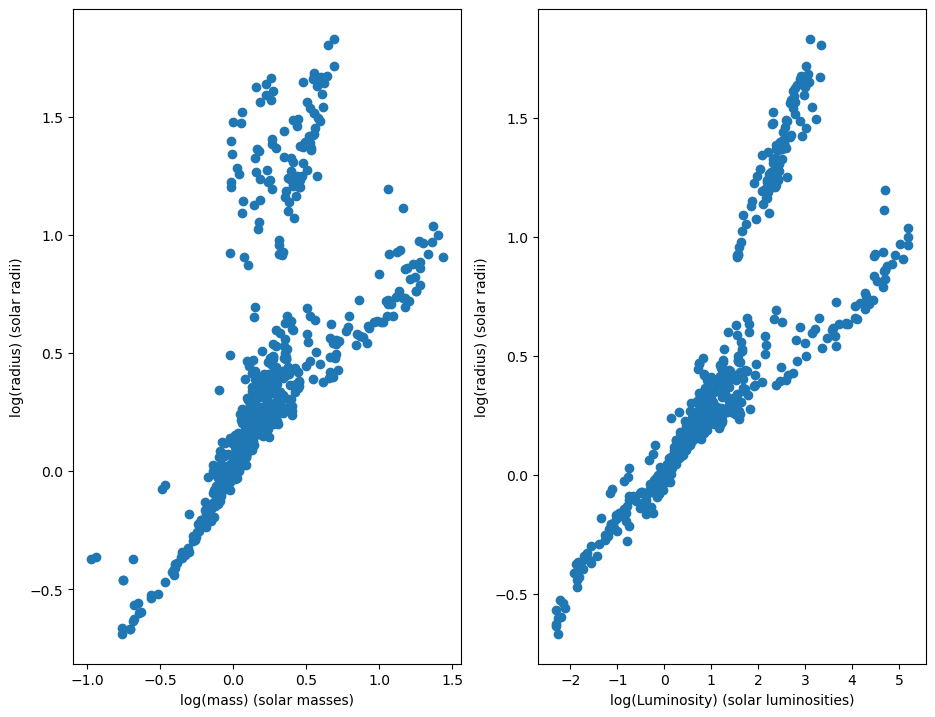

In [4]:
# Plot the logarithm of mass with the logarithm of radius, and the logarithm of luminosity with the logarithm of radius.
fig, axs = plt.subplots(1, 2, figsize=[11, 8.5])
axs[0].set_xlabel("log(mass) (solar masses)")
axs[0].set_ylabel("log(radius) (solar radii)")
axs[0].scatter(binaries['logM'], binaries['logR'])

axs[1].set_xlabel("log(Luminosity) (solar luminosities)")
axs[1].set_ylabel("log(radius) (solar radii)")
axs[1].scatter(binaries['logL'], binaries['logR'])

There are two clusters that we can see here. The lower cluster corresponds to stars on the main sequence, which are stars that burn mostly hydrogen and have not reached the end of their evolution. The higher cluster corresponds to stars that are giants, meaning that they are reaching the end of their lives and have little hydrogen to fuse.

Luckilly, the dataset provides us a way to differentiate between main sequence stars and giant stars. The dataset gives us the stellar classification of a star, which also has information about whether a star is on the main sequence or not. When we separate main sequence stars from giants we get this plot:

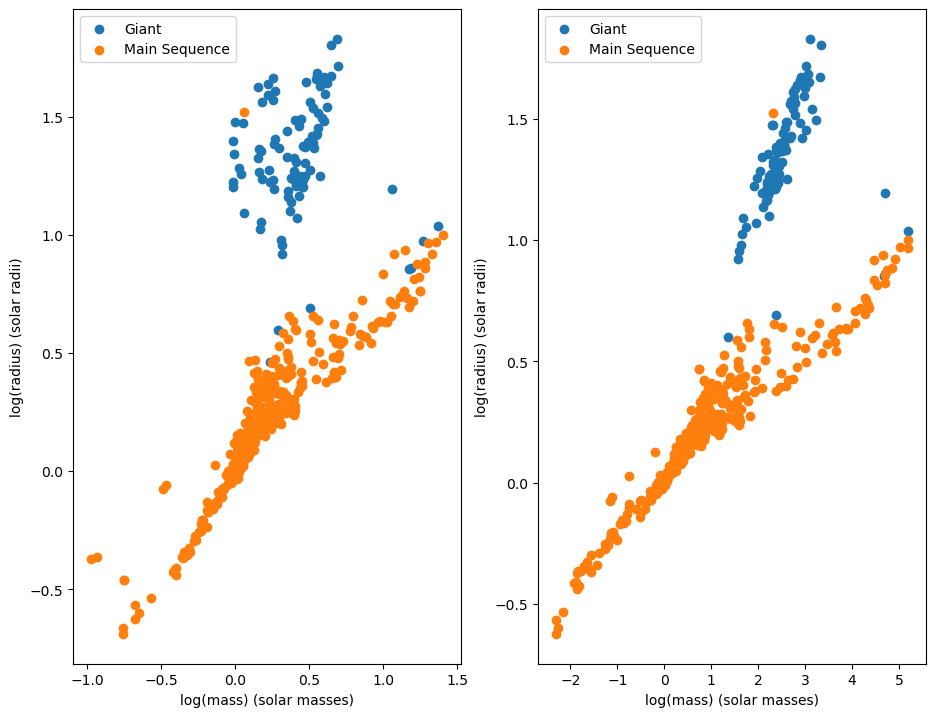

In [5]:
color_mapping = {"Main Sequence": 0, "Giant": 1, "Unknown": 2}
def classify(classification):
    # If the "Yerkes luminosity class" is IV or V, then the star is considered main sequence
    main_sequence_markers = ['_IV', '_V']
    giant_markers = ['_I', '_II', '_III']
    if any([marker in classification for marker in main_sequence_markers]):
        return "Main Sequence"
    if any([marker in classification for marker in giant_markers]):
        return "Giant"
    return "Unknown"

binaries['c'] = binaries.apply(lambda x: classify(x['SpT']), axis=1)

# filter for only known classifications
binaries_known = binaries[binaries['c'] != "Unknown"]
fig, axs = plt.subplots(1, 2, figsize=[11, 8.5])
groups = binaries_known.groupby("c")
for name, group in groups:
    axs[0].set_xlabel("log(mass) (solar masses)")
    axs[0].set_ylabel("log(radius) (solar radii)")
    axs[1].set_xlabel("log(mass) (solar masses)")
    axs[1].set_ylabel("log(radius) (solar radii)")
    axs[0].scatter(group['logM'], group['logR'], label=name)
    axs[1].scatter(group['logL'], group['logR'], label=name)
axs[0].legend()
axs[1].legend()

The main sequence stars seem to obey a relationship between mass and radius, so we will attempt to predict the radius of a main sequence star using a linear regression model.

In [6]:
lr_model = LinearRegression()

# Filter for only main sequence stars with an observed luminosity
binaries_mainSeq = binaries[binaries['c'] == "Main Sequence"]
binaries_mainSeq = binaries_mainSeq.dropna()

X = binaries_mainSeq[['logM', 'logL']]
y = binaries_mainSeq['logR']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/3, random_state=42086192)

lr_model.fit(X_train, y_train)
train_score = lr_model.score(X_train, y_train)
print(f"The model's score on the training data is {train_score}")
test_score = lr_model.score(X_test, y_test)
print(f"The model's score on the testing data is {test_score}")
print(lr_model.coef_, lr_model.intercept_)

The model's score on the training data is 0.9305131827685944
The model's score on the testing data is 0.8867788885584653
[-0.64651062  0.35158324] 0.03950482057602028


We can also try to use a k-nearest neighbor regression model. We will check which model performs the best by determining which value of k produces the best testing score.

The best model was when k was equal to 7 with a testing score of 0.880189063188313


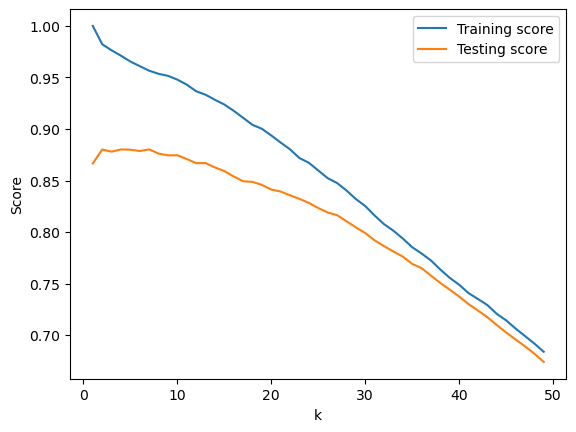

In [7]:
scores = []
for k in range(1, 50):
  knn_model = KNeighborsRegressor(n_neighbors=k)
  knn_model.fit(X_train, y_train)

  train_score = knn_model.score(X_train, y_train)
  test_score = knn_model.score(X_test, y_test)
  scores.append((k, train_score, test_score))

best_score = max(scores, key = lambda x: x[2])
print(f"The best model was when k was equal to {best_score[0]} with a testing score of {best_score[2]}")
k = [score[0] for score in scores]
train_score = [score[1] for score in scores]
test_score = [score[2] for score in scores]
fig, ax = plt.subplots()
ax.set_xlabel("k")
ax.set_ylabel("Score")
ax.plot(k, train_score, label="Training score")
ax.plot(k, test_score, label ="Testing score")
ax.legend()

We can improve the R^2 of both models by performing k-fold cross validation. When we do so, the R^2 goes from 0.88 to 0.90 for the linear model, and to 0.91 for the k-nearest-neighbor model

In [8]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42086192)
lr_scores = []
knn_scores = []
k = 1
for train, test in kf.split(binaries_mainSeq):
  X_train, X_test = X.iloc[train], X.iloc[test]
  
  y_train, y_test = y.iloc[train], y.iloc[test]
  lr_model = LinearRegression()
  knn_model = KNeighborsRegressor(n_neighbors=7)
  lr_model.fit(X_train, y_train)
  lr_score = lr_model.score(X_test, y_test)
  print(f"Linear Model - Fold {k}: R^2 = {lr_score}")
  lr_scores.append(lr_score)
  knn_model.fit(X_train, y_train)
  knn_score = knn_model.score(X_test, y_test)
  knn_scores.append(knn_score)
  print(f"K-nearest-neighbor model- Fold {k}: R^2 = {knn_score}")
  k += 1
print(f"Linear Model average R^2: {np.mean(lr_scores)}")
print(f"K-nearest-neighbor average R^2: {np.mean(knn_scores)}")

Linear Model - Fold 1: R^2 = 0.9149201016026459
K-nearest-neighbor model- Fold 1: R^2 = 0.919196127996394
Linear Model - Fold 2: R^2 = 0.8805677542455563
K-nearest-neighbor model- Fold 2: R^2 = 0.8402608668355813
Linear Model - Fold 3: R^2 = 0.8503569898188309
K-nearest-neighbor model- Fold 3: R^2 = 0.9052802382659894
Linear Model - Fold 4: R^2 = 0.9338817400759195
K-nearest-neighbor model- Fold 4: R^2 = 0.9368006462431022
Linear Model - Fold 5: R^2 = 0.9222375179595681
K-nearest-neighbor model- Fold 5: R^2 = 0.9588169832119561
Linear Model average R^2: 0.9003928207405043
K-nearest-neighbor average R^2: 0.9120709725106046


In the scatterplot shown earlier, there is a clear line between giants and main-sequence stars. So, we should expect that logistic regression can help us predict the classification of a star as a giant or a main-sequence star.

We will test which features we should use for our logistic regression model.

In [9]:
from sklearn.linear_model import LogisticRegression
from itertools import combinations, chain
# taken from https://docs.python.org/3/library/itertools.html#itertools-recipes 
# needed to create a list of all subsets
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

all_features = ['logM', 'logL', 'logR']
powerset = powerset(all_features)
binaries_known = binaries_known.dropna()
for features in powerset:
  if features == (): continue
  features = list(features)
  X = binaries_known[features]
  y = binaries_known['c']
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/3, random_state=42086192)
  clf = LogisticRegression()
  clf.fit(X, y)
  accuracy = clf.score(X, y)
  print(f"Testing accuracy with {features}: {accuracy}")

Testing accuracy with ['logM']: 0.7713625866050808
Testing accuracy with ['logL']: 0.7182448036951501
Testing accuracy with ['logR']: 0.9745958429561201
Testing accuracy with ['logM', 'logL']: 0.8752886836027713
Testing accuracy with ['logM', 'logR']: 0.9838337182448037
Testing accuracy with ['logL', 'logR']: 0.9838337182448037
Testing accuracy with ['logM', 'logL', 'logR']: 0.9838337182448037


From this, it seems that logR is the best single variable that we should use for predicting stellar classification. When we add another variable alongside logM to help with our predictions, the prediction ends up being the best it can possibly be.

When we plot out the decision boundary for logM and logR, we find this:

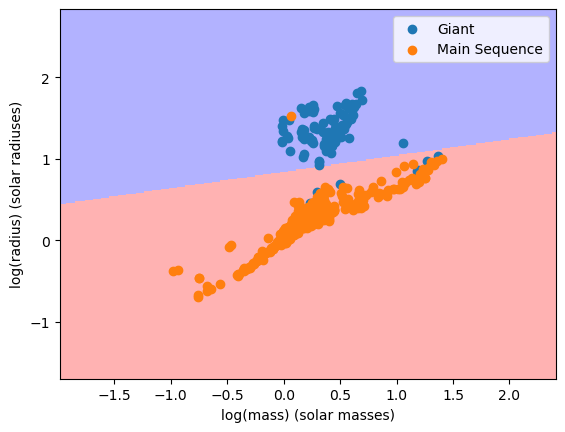

In [10]:
from sklearn.inspection import DecisionBoundaryDisplay
# We dropped the binaries with unknown luminosities earlier, so we have to redefine this variable
binaries_known = binaries[binaries['c'] != "Unknown"]
groups = binaries_known.groupby('c')
fig, ax = plt.subplots()
clf = LogisticRegression()
X = binaries_known[['logM', 'logR']]
y = binaries_known['c']
clf = clf.fit(X, y)
DecisionBoundaryDisplay.from_estimator(clf, X, grid_resolution=300, response_method="predict", ax=ax, alpha=0.3, plot_method='pcolormesh', cmap='bwr')

for name, group in groups:
  x = group['logM']
  y = group['logR']
  ax.set_xlabel("log(mass) (solar masses)")
  ax.set_ylabel("log(radius) (solar radiuses)")
  ax.scatter(x, y, label=name)
ax.legend()

and when we look at the confusion matrix of this model, we find this:

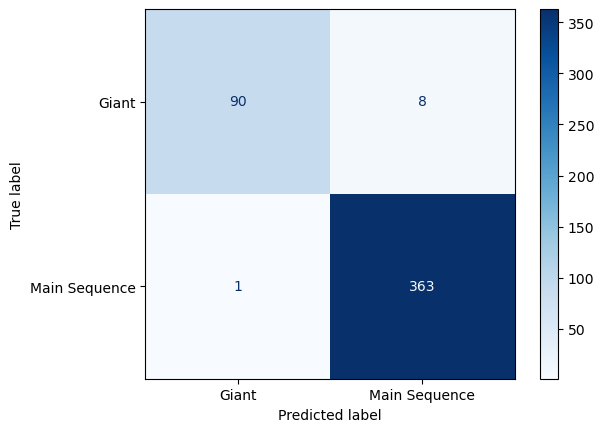

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
X = binaries_known[['logM', 'logR']]
y = binaries_known['c']
fig, ax = plt.subplots()
display = ConfusionMatrixDisplay.from_estimator(clf, X, y, ax=ax, cmap='Blues')

Since only one main sequence star out of 337 was predicted incorrectly, and eight out of 96 giants were predicted incorrectly, this model is good.

One final thing we can do is to look at the distribution of masses in our data. One way we can do this is by using a histogram.

(array([0.02482597, 0.04965194, 0.11171686, 0.03723895, 0.11171686,
        0.13654283, 0.39721552, 0.83166999, 1.650927  , 1.75023088,
        1.10475566, 0.7447791 , 0.39721552, 0.28549865, 0.06206492,
        0.09930388, 0.13654283, 0.1613688 , 0.13654283, 0.06206492]),
 array([-0.9763, -0.8557, -0.7351, -0.6145, -0.4939, -0.3733, -0.2527,
        -0.1321, -0.0115,  0.1091,  0.2297,  0.3503,  0.4709,  0.5915,
         0.7121,  0.8327,  0.9533,  1.0739,  1.1945,  1.3151,  1.4357]),
 <BarContainer object of 20 artists>)

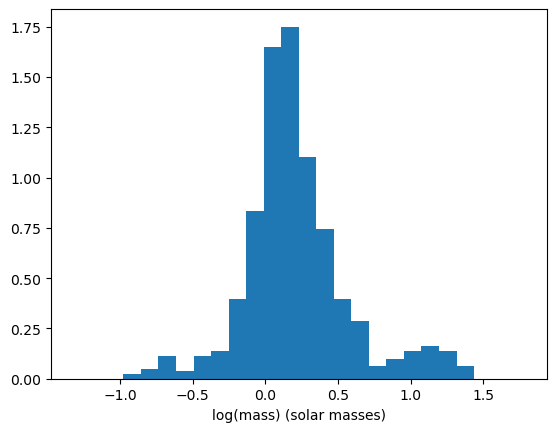

In [12]:
masses = binaries[['logM']]
fig, ax = plt.subplots()
ax.set_xlim(left=np.min(masses - 0.5), right=np.max(masses) + 0.5)
ax.set_xlabel("log(mass) (solar masses)")
ax.hist(masses, bins=20, density=True)

A problem with using histograms is the choice of where to put the bins can result in the histogram being shaped differently. For example, if the histogram had 19 bins instead of 20, we get this histogram.

(array([0.02358467, 0.04716934, 0.10613102, 0.05896168, 0.11792336,
        0.21226204, 0.50707044, 1.06131022, 2.00469707, 1.36791094,
        0.88442518, 0.45990109, 0.30660073, 0.15330036, 0.08254635,
        0.09433869, 0.18867737, 0.14150803, 0.05896168]),
 array([-0.9763    , -0.84935263, -0.72240526, -0.59545789, -0.46851053,
        -0.34156316, -0.21461579, -0.08766842,  0.03927895,  0.16622632,
         0.29317368,  0.42012105,  0.54706842,  0.67401579,  0.80096316,
         0.92791053,  1.05485789,  1.18180526,  1.30875263,  1.4357    ]),
 <BarContainer object of 19 artists>)

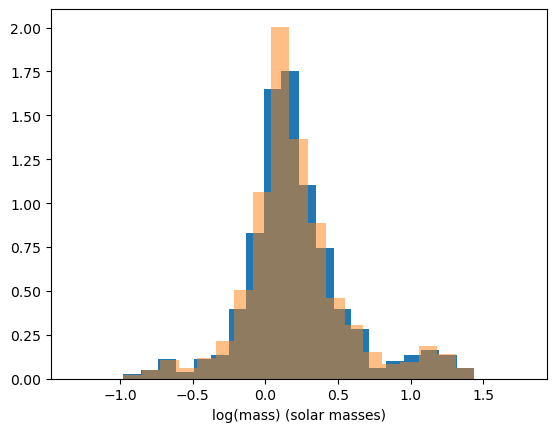

In [13]:
masses = binaries[['logM']]
fig, ax = plt.subplots()
ax.set_xlim(left=np.min(masses - 0.5), right=np.max(masses) + 0.5)
ax.set_xlabel("log(mass) (solar masses)")
ax.hist(masses, bins=20, density=True)

# New histogram, where the range expands in 0.5 in each direction
ax.hist(masses, bins=19, density=True, alpha=0.5)

Our choice to create 19 bins insteead of 20 created a sharper peak around x=0.2, so our choice on how many bins we create or where the bins are placed has a great effect on how the distribution looks in the histogram. Another way that we can represent the distribution is by using kernel density estimation.

The way kernel density estimation works is that is an estimation of the probability density of a discrete set of points. To calculate the density at point x for a set of points $x_1, x_2, x_3, \dots, x_n$, you need to take the sum
$$\rho(x) = \sum_{i=1}^{n} K(x - x_i, h)$$
Where $K(x, h)$ is what is known as the kernel function which is controlled by the bandwidth parameter h.

For this project, we will be using the gaussian function as our kernel density function. It is defined as
$$K(x, h) = e^{\frac{-x^2}{2h^2}}$$

(array([0.02482597, 0.04965194, 0.11171686, 0.03723895, 0.11171686,
        0.13654283, 0.39721552, 0.83166999, 1.650927  , 1.75023088,
        1.10475566, 0.7447791 , 0.39721552, 0.28549865, 0.06206492,
        0.09930388, 0.13654283, 0.1613688 , 0.13654283, 0.06206492]),
 array([-0.9763, -0.8557, -0.7351, -0.6145, -0.4939, -0.3733, -0.2527,
        -0.1321, -0.0115,  0.1091,  0.2297,  0.3503,  0.4709,  0.5915,
         0.7121,  0.8327,  0.9533,  1.0739,  1.1945,  1.3151,  1.4357]),
 <BarContainer object of 20 artists>)

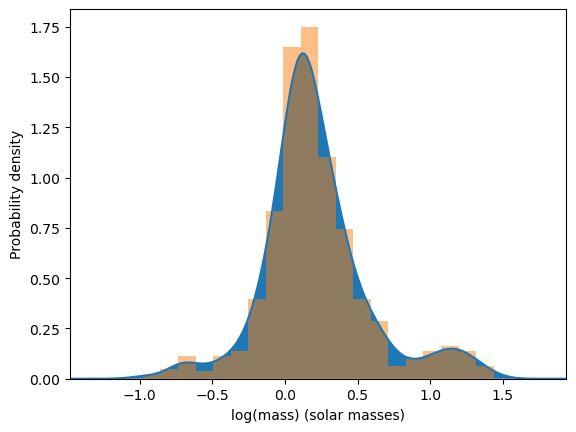

In [14]:
from sklearn.neighbors import KernelDensity

# Set up a KernelDensity object
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(masses.values)
X = np.linspace(np.min(masses) - 0.5, np.max(masses) + 0.5, 200)
# score_samples() gives the log of the density, so we have to do np.exp() to get the estimated probability density
y = np.exp(kde.score_samples(X.reshape(-1, 1)))

fig, ax = plt.subplots()
ax.set_xlim(left=np.min(masses - 0.5), right=np.max(masses) + 0.5)
ax.set_xlabel("log(mass) (solar masses)")
ax.set_ylabel("Probability density")
# Plot the kernel density function
ax.plot(X, y)
ax.fill_between(X, 0, y)
# Plot the histogram for comparison
ax.hist(masses, bins=20, density=True, alpha=0.5)

The bandwidth of the kernel density estimator changes how the density of the distribution looks. Setting it to a lower number makes the distribution look more rough, while setting it to a higher number makes the distribution look more smooth. To see this in action, we will be making multiple plots where the bandwidth varies each time.

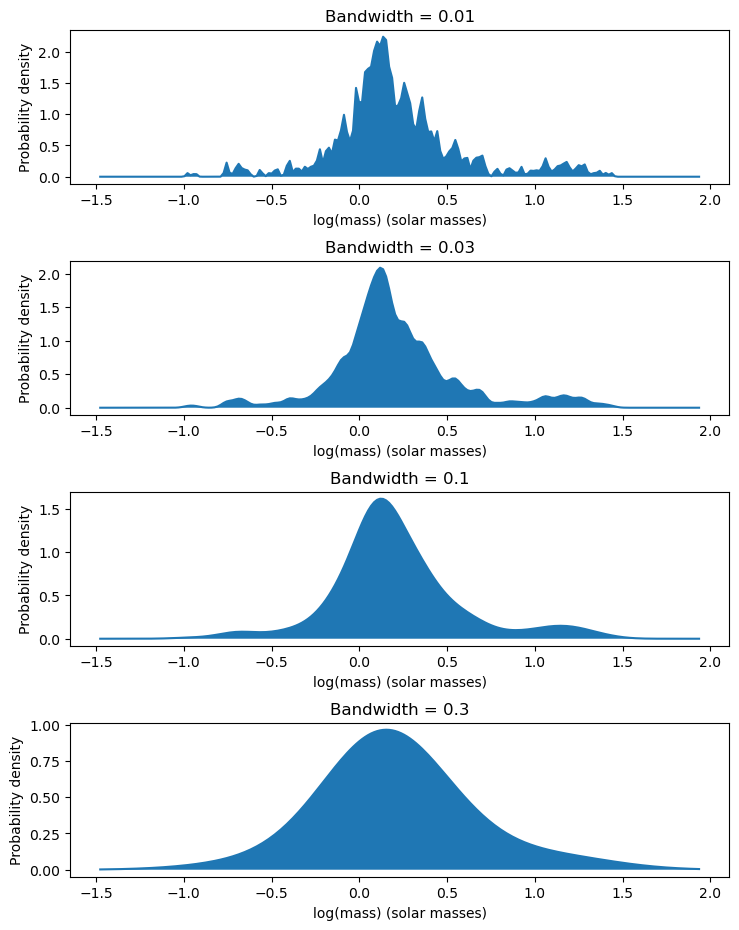

In [15]:
bandwidths = [0.01, 0.03, 0.1, 0.3]
fig, ax = plt.subplots(4, figsize=[8.5, 11])
# Adjust the spacing between plots
plt.subplots_adjust(hspace=0.5)
X = np.linspace(np.min(masses) - 0.5, np.max(masses) + 0.5, 200)
for num, bandwidth in enumerate(bandwidths):
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(masses.values)
    y = np.exp(kde.score_samples(X.reshape(-1, 1)))
    ax[num].set_xlabel("log(mass) (solar masses)")
    ax[num].set_ylabel("Probability density")
    ax[num].set_title(f"Bandwidth = {bandwidth}")
    ax[num].plot(X, y)
    ax[num].fill_between(X, 0, y)